<img align="right" src="../../additional_data/banner_siegel.png" style="width:1000px;">

# Data Lookup and Loading

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Products used**: `Sentinel-2`
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube.ipynb)

## Background

A "datacube" is a digital information architecture that specialises in hosting and cataloguing spatial information. Eo2cube is based on the [Open Data Cube](https://www.opendatacube.org/) infrastructure and specialises in storing remotely sensed data, particularly from Earth Observation satellites such as Landsat and Sentinel-2. The eo2cube contains multiple analyse ready satellite data "products". These data products are often composed of a range of "measurements" such as the suite of remote sensing band values. This notebook will focus on several straightforward ways to inspect the product,  measurement of a datacube, as well as to run data query and loading the data using a wide range of options, including resampling and interpolation.

## Description

This notebook demonstrates how to **browse the available products/ measurements** stored within, and how to **load data** from the eo2cube datacube by using the `dc.load()` function. Topics covered include:

* How to connect to the datacube
* How to list all the products/ measurements
* Loading data with the `dc.load()`function
* Customising the `dc.load()`query
* Tips and tricks to simplify the data loading process

***

## Load packages

The `datacube` package is required to query the eo2cube datacube database and load the requested data. The pandas package is required to format tables. The `with_ui_cbk` function from `odc.ui` enables a progress bar when loading large amounts of data

In [4]:
import datacube
import pandas as pd
from odc.ui import with_ui_cbk

# Set some configurations for displaying tables nicely
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)

## Datacube connection

After importing the datacube package, you are ready to connect to the eo2cube datacube. Users need to specify a name for their session, known as the app name. This name is generated by the user and is used to track down issues with database queries. It does not have any effect on the analysis. Use a short name that is consistent with the purpose of your notebook such as the way 03_Products_and_measurements has been used as the app name in this notebook.

The resulting dc object provides access to all the data contained within the eo2cube datacube.

In [5]:
dc = datacube.Datacube(app = '03_Products_and_measurement') #datacube connection

## List products

Once a datacube instance has been created, users can explore the products and measurements stored within.
The following cell lists all products that are currently available in the eo2cube datacube by using the dc.list_products() function.

In [6]:
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
dem_cop_30,dem_cop_30,Copernicus DEM 30 m,None,EPSG:4326,"(-0.0002777777777777778, 0.0002777777777777778)"
esa_worldcover,esa_worldcover,"ESA World Cover, global 10 m land use/land cover data from 2020.",None,EPSG:4326,"(-8.333333333333333e-05, 8.333333333333333e-05)"
s1_coherence_vv_asc,s1_coherence_vv_asc,Sentinel-1 Coherence Product (ascending),None,None,None
s1_rtc,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,CC-BY-4.0,EPSG:4326,"(-0.0002, 0.0002)"
s2_indices,s2_indices,Indices derived from Sentinel-2 data,None,None,None
s2_l2a,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed to Level 2A (Surface Reflectance) and converted to Cloud Optimized GeoTIFFs",None,None,None


## List measurements

Every product is associated with a range of available measurements. For the most time, these are the individual satellite bands.

The dc.list_measurements() function can be used to interrogate the measurements associated with a given product (specified by the name column from the table above). For example, s2_l2a_bavaria refers to the Sentinel 2 ARD L2A scenes product for Bavaria.

In [7]:
product = "s1_rtc"
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,flags_definition,aliases
measurement,,,,,,
vv,vv,float32,1,NaN,NaN,[VV]
vh,vh,float32,1,NaN,NaN,[VH]
angle,angle,uint8,1,255.0,NaN,"[ANGLE, local_incidence_angle]"
area,area,float32,1,NaN,NaN,"[AREA, normalised_scattering_area]"
mask,mask,uint8,1,0.0,"{'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values': {'0': 'no data', '1': 'valid data', '2': 'invalid data'}}}",[MASK]


## Display Map
Before loading the data, it is a good idea to first check out the area of interest in a map. We can use display_map function for that.

**Don't forget to import function `display_map` from `DEAPlotting` when you load the libraries.**

In [8]:
from dea_tools.plotting import display_map

display_map([24.75 ,24.88],[-28.93, -28.81], crs = 'EPSG:4326')

## Loading data with the `dc.load()`function

Loading data from the datacube uses the `dc.load()` function.

The function requires the following minimum arguments:

* product: The data product to load (to see all available eo2cube products, see the [Products and measurements notebook](03_products_and_measurements.ipynb)).
* x: The spatial region in the x dimension. By default, the x and y arguments accept queries in a geographical co-ordinate system WGS84, identified by the EPSG code 4326.
* y: The spatial region in the y dimension. The dimensions longitude/latitude and x/y can be used interchangeably. It is also possible to use the extent of an imported shapefile as x/y (see the [notebook for working with vectordata](XX_vectordata.ipynb)).
* time: The temporal extent. The time dimension can be specified using a tuple of datetime objects or strings in the “YYYY”, “YYYY-MM” or “YYYY-MM-DD” format.
* output_crs: Reproject the data from the default or stored CRS into a specified CRS
* resolution: Defines the output resolution

The used product is defined by its name. The spatial extent is defined by lat/lon coordinates. The time intervall ist defined by the format "YYYY-MM-DD". The argument `progess_cbk` with the imported `with_ui_cbk()`function enables loading bar.

In [19]:
data = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               time= ("2019-01-01", "2019-01-15"),
               output_crs = "EPSG:32734",
               resolution = (-10, 10),
               progress_cbk=with_ui_cbk())


In [20]:
data

<xarray.Dataset>
Dimensions:      (time: 3, y: 1031, x: 1010)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T08:28:09 ... 2019-01-15T08:...
  * y            (y) float64 6.807e+06 6.807e+06 ... 6.797e+06 6.797e+06
  * x            (x) float64 8.687e+05 8.687e+05 ... 8.787e+05 8.788e+05
    spatial_ref  int32 32734
Data variables: (12/15)
    B01          (time, y, x) uint16 711 711 711 711 711 ... 579 621 621 621 621
    B02          (time, y, x) uint16 930 904 888 852 859 ... 804 792 551 611 850
    B03          (time, y, x) uint16 1390 1370 1356 1334 ... 1112 918 1030 1262
    B04          (time, y, x) uint16 2116 2050 1994 1972 ... 1728 1282 1556 1874
    B05          (time, y, x) uint16 2412 2412 2317 2317 ... 1881 1697 1987 1987
    B06          (time, y, x) uint16 2483 2483 2429 2429 ... 2125 2000 2200 2200
    ...           ...
    B09          (time, y, x) uint16 2732 2732 2732 2732 ... 2662 2662 2662 2662
    B11          (time, y, x) uint16 4106 4106 4037 4037 ... 4041 3839 4093 4093
    B12          (time, y, x) uint16 3601 3601 3500 3500 ... 3139 2928 3212 3212
    SCL          (time, y, x) uint8 5 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5 5
    AOT          (time, y, x) uint16 168 168 168 168 168 ... 168 168 168 168 168
    WVP          (time, y, x) uint16 1636 1636 1601 1601 ... 453 445 455 455
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

## Customization of the `dc.load()` function

The query created above only used the basic arguments of the `dc.load()` function. However, it is possible to customize your loading query by using multiple other arguments. A detailed description of every useable argument can be found in the [original documentation of the `dc.load()` function](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.Datacube.load.html) of the Opendatacube initiative. In this notebook we will present the most used arguments that allow easy and effective querying of eo2cube products.

### Specifying Measurements
<a id='first_query'></a>
The `measurements` argument provides the option to filter the desired product by its bands. This argument takes a list of the names of the desired measurement, as listed in the `dc.list_measurements()` function (see [notebook 03](03_products_and_measurements.ipynb)). If not provided, all stored measurements of the product will be loaded.

In the following code only the `blue`, `green` and `red` bands of the specified product are added to the query. The resulting dataset will only include the defined measurements.

In [21]:
data = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               time= ("2019-01-01", "2019-01-15"),
               measurements= ["blue", "green", "red"],
               output_crs = "EPSG:4326",
               resolution = (10,10),
               progress_cbk=with_ui_cbk())

data

<xarray.Dataset>
Dimensions:      (time: 3, latitude: 1, longitude: 1)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T08:28:09 ... 2019-01-15T08:...
  * latitude     (latitude) float64 -25.0
  * longitude    (longitude) float64 25.0
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) uint16 0 0 0
    green        (time, latitude, longitude) uint16 0 0 0
    red          (time, latitude, longitude) uint16 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Specifying CRS and Reprojecting 

To reproject the data from the default or stored CRS into a specified CRS, it is neccessary to define the `output_crs` and a new `resolution` for your data. The unit of the new `output_crs` and `resolution`must identical.

In [22]:
data = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               measurements= ["blue", "green", "red"],
               time= ("2019-01-01", "2019-01-15"),
               output_crs = "EPSG:4326",
               resolution = (-0.0002734477121776, 0.0002734477121776),
               progress_cbk=with_ui_cbk())

data

<xarray.Dataset>
Dimensions:      (time: 3, latitude: 330, longitude: 367)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-05T08:28:09 ... 2019-01-15T08:...
  * latitude     (latitude) float64 -28.81 -28.81 -28.81 ... -28.9 -28.9 -28.9
  * longitude    (longitude) float64 24.78 24.78 24.78 ... 24.88 24.88 24.88
    spatial_ref  int32 4326
Data variables:
    blue         (time, latitude, longitude) uint16 797 790 813 ... 739 660 719
    green        (time, latitude, longitude) uint16 1158 1163 1207 ... 994 1103
    red          (time, latitude, longitude) uint16 1639 1687 1760 ... 1556 1637
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

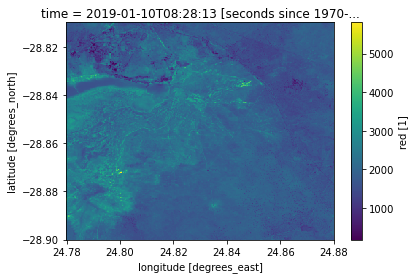

In [23]:
data.red.isel(time=1).plot()

### Spatial resampling

To resample the data to another resolution, multiple resampling methods are available. You can define the `resampling` argument with one method from the following:
`"nearest", "cubic", "bilinear", "cubic_spline", "lanczos", "average", "mode", "gauss", "max", "min", "med", "q1", "q3"`.
By default, the `dc.load()` function is using "nearest neighbour" resampling, which allocates each new pixel with the value of the closest input pixel. However, for some data (eg. continuous data) this may not be the most appropiate choice.

The example code below, resamples the specified product to a greater resolution of (-30, 30) meters using the bilinear interpolation method (`bilinear`). Note that the absolute number of pixels has been halved as the dataset has been resampled to twice the pixel size ([compare with the first query](#first_query))

In [24]:
data_10 = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               time= ("2020-04-01", "2020-04-15"),
               measurements= ["blue", "green", "red"],
               output_crs = "EPSG:32734",
               resolution = (-10,10),
               progress_cbk=with_ui_cbk())
    
data_30 = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               time= ("2020-04-01", "2020-04-15"),
               measurements= ["blue", "green", "red"],
               output_crs = "EPSG:32734",
               resolution = (-60,60),
               resampling = "bilinear",
               progress_cbk=with_ui_cbk())

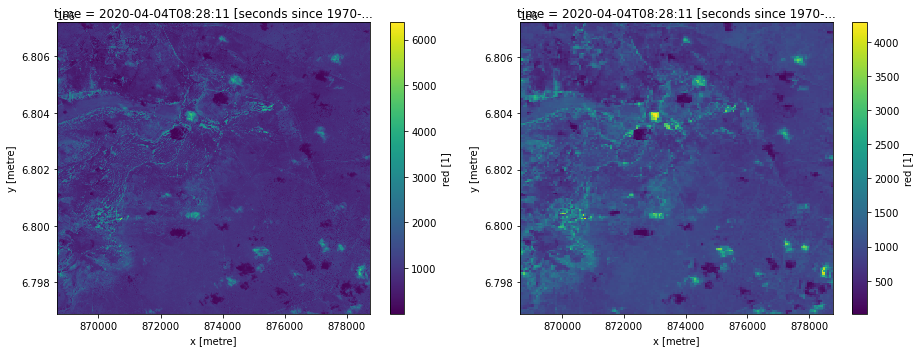

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(13,5))


data_10.red.isel(time=1).plot(ax=axes[0])
data_30.red.isel(time=1).plot(ax=axes[1])
plt.tight_layout()
plt.show()

It is also possible to define different resampling methods for different measurements. This is useful if a dataset stores continuous data and categorical data. For example, the Sentinel-2 dataset has a scene classification layer (`scl`) which contains categorical values about the quality of a single pixel. If you want to resample your continuous data to another resolution with the `bilinear` method but also include the categorical `scl` band (categorical) it is best to use an interpolation method that does not modify the data directly for the resampling of the categorical `scl` band. 

This can be done by using Python Dictionaries as value for the `resampling` argument. The following code resample continuous bands with `bilinear` interpolation but also uses the `nearest` (which does not modify the data values) for the categorical `scl` band.

In [26]:
data = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               time= ("2020-04-01", "2020-04-15"),
               measurements= ["blue", "green", "red"],
               output_crs = "EPSG:32734",
               resolution = (-20, 20),
               resampling = {"*": "bilinear", "scl": "nearest"},
               progress_cbk=with_ui_cbk())


data

<xarray.Dataset>
Dimensions:      (time: 5, y: 516, x: 505)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-02T08:38:05 ... 2020-04-14T08:...
  * y            (y) float64 6.807e+06 6.807e+06 ... 6.797e+06 6.797e+06
  * x            (x) float64 8.687e+05 8.687e+05 ... 8.787e+05 8.788e+05
    spatial_ref  int32 32734
Data variables:
    blue         (time, y, x) uint16 560 469 401 354 379 ... 3404 3608 3774 4184
    green        (time, y, x) uint16 763 621 572 518 493 ... 3176 3418 3626 3920
    red          (time, y, x) uint16 750 589 528 440 431 ... 3034 3230 3508 3708
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

### Group by argument

The `group_by` argument is a useful tool to combine/mosaic multiple scenes of one date (e.g. if the extent is visible in two sequential scenes of the satellite). Satellite datasets can have multiple observations per day with slightly different time stamps as the satellite collects data along its path. These observations can be combined by reducing the time dimension to the day level using `group_by = "solar_day"`. By default the scenes are simply copied together (e.g. the NA values of the first scene are filled with the values of the second scene). With the argument "fuse_func" the mosaicing can be controlled by the user (e.g. specify an interpolation method).

This example loads data for the first week in April 2020. Since the extent of the AOI is to big to be covered by just one Sentinel 2 scene there are multiple scenes (from contiguous paths) available for each date. By using the `group_by = "solar_day"` argument the `dc.load()` function automatically mosaics all scenes of a single date together. In this example no special interpolation method was defined.

In [27]:
data = dc.load(product= "s2_l2a",
               x= (24.78 ,24.88),
               y= (-28.90, -28.81),
               time= ("2020-04-01", "2020-04-15"),
               measurements= ["blue", "green", "red"],
               output_crs = "EPSG:32734",
               resolution = (-20, 20),
               group_by = "solar_day",
               progress_cbk=with_ui_cbk())

data

<xarray.Dataset>
Dimensions:      (time: 5, y: 516, x: 505)
Coordinates:
  * time         (time) datetime64[ns] 2020-04-02T08:38:05 ... 2020-04-14T08:...
  * y            (y) float64 6.807e+06 6.807e+06 ... 6.797e+06 6.797e+06
  * x            (x) float64 8.687e+05 8.687e+05 ... 8.787e+05 8.788e+05
    spatial_ref  int32 32734
Data variables:
    blue         (time, y, x) uint16 560 469 401 354 379 ... 3404 3608 3774 4184
    green        (time, y, x) uint16 763 621 572 518 493 ... 3176 3418 3626 3920
    red          (time, y, x) uint16 750 589 528 440 431 ... 3034 3230 3508 3708
Attributes:
    crs:           EPSG:32734
    grid_mapping:  spatial_ref

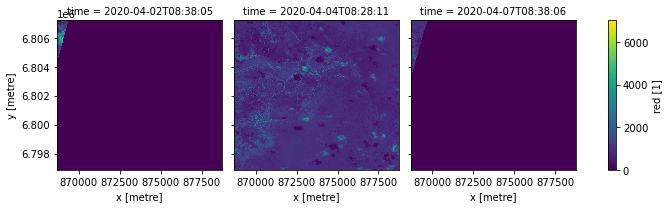

In [28]:
data.red.isel(time=[0,1,2]).plot(col="time")

## Recommended next steps

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/01_jupyter_introduction.ipynb)
2. [eo2cube](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/02_eo2cube_introduction.ipynb)
3. ***Loading Data (this notebook)***
4. [Xarray I: Data Structure](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/04_xarrayI_data_structure.ipynb)
5. [Xarray II: Index and Statistics](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/05_xarrayII.ipynb)
6. [Plotting data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb)
7. [Spatial analysis](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_basic_analysis.ipynb)
8. [Parallel processing with Dask](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/08_parallel_processing_with_dask.ipynb)

The additional notebooks are designed for users to build up both basic and advanced skills which are not covered by the beginner's guide. Self-motivated users can go through them according to their own needs. They act as complements for the guide:
<br>

1. [Python's file management tools](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/I_file_management.ipynb)
2. [Image Processing basics using NumPy and Matplotlib](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/II_numpy_image_processing.ipynb)
3. [Vector Processing](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/III_process_vector_data.ipynb)
4. [Advanced Plotting](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb)

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks! </font>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** January 2021